In [ ]:
# default_exp doublediff_analysis

In [ ]:
#export
def calc_per_peppair_z_and_fcfc(overlapping_c1_idx, overlapping_c2_idx, ion1_c1_ints, ion1_c2_ints, ion2_c1_ints, ion2_c2_ints, ddeed_ion1_ion2):
    fcfc_res = 0
    count_fcfcs = 0
    z_summed = 0
    for idx1 in overlapping_c1_idx:
        for idx2 in overlapping_c2_idx:
            fc_ion1 = ion1_c1_ints[idx1] - ion1_c2_ints[idx2]
            fc_ion2 = ion2_c1_ints[idx1] - ion2_c2_ints[idx2]
            fcfc_idxpair = fc_ion1 - fc_ion2
            z_idxpair = ddeed_ion1_ion2.calc_zscore_from_fc(fcfc_idxpair)
            fcfc_res += fcfc_idxpair
            z_summed += z_idxpair
            count_fcfcs+=1
    if count_fcfcs==0:
        raise Exception("no idx overlap even though filtering has happened!")

    return z_summed, fcfc_res/count_fcfcs





def calculate_pairpair_overlap_factor(all_ionpairs, ion2pairs, ionpair2idx_ols, normed_c1, normed_c2, ion2diffdist, p2z):
    
    secondterm_variance = 0
    
    for ionpair in all_ionpairs:
        for ion in ionpair:
            compare_pairs = ion2pairs.get(ion)
            compare_pairs.remove(ionpair)
            
            for comp_ionpair in compare_pairs:

                comp_ion = comp_ionpair[0]

                idxs_ionpair = ionpair2idx_ols.get(ionpair)
                idxs_comp_ionpair = ionpair2idx_ols.get(comp_ionpair)
                
                n_sameidx_first = len(set(idxs_ionpair[0]).intersection(set(idxs_comp_ionpair[0])))
                n_sameidx_second = len(set(idxs_ionpair[1]).intersection(set(idxs_comp_ionpair[1])))

                deed1 = aqbg.get_subtracted_bg(ion2diffdist, normed_c1, normed_c2, ion, p2z)
                deed2 = aqbg.get_subtracted_bg(ion2diffdist, normed_c1, normed_c2, comp_ion, p2z)

                eed_ion_c1 = normed_c1.ion2background.get(ion)
                eed_ion_c2 = normed_c2.ion2background.get(ion)

                correlation_normfact = deed1.SD * deed2.SD
                
                var_overlap = len(idxs_ionpair[1])*len(idxs_comp_ionpair[1]) * n_sameidx_first * eed_ion_c1.var + len(idxs_ionpair[0])*len(idxs_comp_ionpair[0]) * n_sameidx_second * eed_ion_c2.var
                secondterm_variance += var_overlap/correlation_normfact
                
    return secondterm_variance

from scipy.stats import norm
def calculate_scaled_pval(z_sum, firstterm_variance, secondterm_variance):
    scaled_SD = np.sqrt((firstterm_variance+secondterm_variance))
    p_val = 2.0 * (1.0 -  norm(loc=0, scale= scaled_SD).cdf(abs(z_sum)))
    return p_val



In [ ]:
#export
import alphaquant.background_distributions as aqbg
import numpy as np


def calc_doublediff_score(ions1, ions2, normed_c1, normed_c2, ion2diffDist, p2z, deedpair2doublediffdist):
    z_total = 0
    fcfc_total = 0
    count_pairs = 0
    firstterm_variance = 0
    all_ionpairs = []
    ion2pairs = {}
    ionpair2idx_ols = {}

    nrep_c1 = len(normed_c1.ion2allvals.get(ions1[0]))
    nrep_c2 = len(normed_c2.ion2allvals.get(ions2[0]))
    
    for ion1 in ions1:
        ion1_c1_ints = normed_c1.ion2allvals.get(ion1)
        ion1_c2_ints = normed_c2.ion2allvals.get(ion1)
        for ion2 in ions2:
            ion2_c1_ints = normed_c1.ion2allvals.get(ion2)
            ion2_c2_ints = normed_c2.ion2allvals.get(ion2)

            #account for missing values: ion1 and ion2 values are only compared within the same sample -> filter for intensities that occur in the same sample for both ions
            overlapping_c1_idx = [x for x in range(nrep_c1) if (~np.isnan(ion1_c1_ints[x])) & (~np.isnan(ion2_c1_ints[x]))]
            nrep_ol_c1 = len(overlapping_c1_idx)
            if nrep_ol_c1 ==0:
                continue

            overlapping_c2_idx = [x for x in range(nrep_c2) if (~np.isnan(ion1_c2_ints[x])) & (~np.isnan(ion2_c2_ints[x]))]
            nrep_ol_c2 = len(overlapping_c2_idx)
            if nrep_ol_c2 ==0:
                continue

            #collection information for later variance calculation
            ionpair = (ion1, ion2)
            all_ionpairs.append(ionpair)
            ion2pairs[ion1] = ion2pairs.get(ion1, []) + [ionpair]
            ion2pairs[ion2] = ion2pairs.get(ion2, []) + [ionpair]
            ionpair2idx_ols[ionpair] = [overlapping_c1_idx, overlapping_c2_idx]

            #define all empirical error distributions (eed) and differential empirical error distributions (deed) and obtain the variance 
            eed_ion1_c1 = normed_c1.ion2background.get(ion1)
            eed_ion1_c2 = normed_c2.ion2background.get(ion1)

            eed_ion2_c1 = normed_c1.ion2background.get(ion2)
            eed_ion2_c2 = normed_c2.ion2background.get(ion2)

            deed_ion1 = aqbg.get_subtracted_bg(ion2diffDist,normed_c1, normed_c2,ion1, p2z)
            deed_ion2 = aqbg.get_subtracted_bg(ion2diffDist,normed_c1, normed_c2,ion2, p2z)

            #calculate the ionpair total variance as shown in Berchtold et al. EmpiReS

            ionpair_variance = (nrep_ol_c1 * nrep_ol_c2 *(deed_ion1.var + deed_ion2.var) + nrep_ol_c1 *nrep_ol_c2 *(nrep_ol_c2-1) * (eed_ion1_c1.var + eed_ion2_c1.var) +
             nrep_ol_c1 *nrep_ol_c2 *(nrep_ol_c1-1) * (eed_ion1_c2.var + eed_ion2_c2.var))/(deed_ion1.var + deed_ion2.var)

            firstterm_variance += ionpair_variance

            #calculate z-value and fcfc for the ion pair
            ddeed_ion1_ion2 = aqbg.get_doublediff_bg(deed_ion1, deed_ion2, deedpair2doublediffdist,p2z)
            z_pair, fcfc_pair = calc_per_peppair_z_and_fcfc(overlapping_c1_idx, overlapping_c2_idx, ion1_c1_ints, ion1_c2_ints, ion2_c1_ints, ion2_c2_ints, ddeed_ion1_ion2)
            z_total+=z_pair
            fcfc_total+=z_pair
            count_pairs+=1
    
    if count_pairs==0:
        return 
    secondterm_variance = calculate_pairpair_overlap_factor(all_ionpairs, ion2pairs, ionpair2idx_ols, normed_c1, normed_c2, ion2diffDist, p2z)
    fcfc = fcfc_total/count_pairs
    pval = calculate_scaled_pval(z_total, firstterm_variance, secondterm_variance)

    return fcfc, pval

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
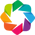

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
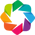

518


A1 protein         A2  \
ion                                                                       
pep0_AND_mod0_AND_mod0_AND_mod0_AND_mod0         NaN      P0        NaN   
pep0_AND_mod0_AND_mod0_AND_mod0_AND_mod1         NaN      P0        NaN   
pep0_AND_mod0_AND_mod0_AND_mod0_AND_mod2         NaN      P0        NaN   
pep0_AND_mod0_AND_mod1_AND_mod0_AND_mod0   10.368302      P0   7.825348   
pep0_AND_mod0_AND_mod1_AND_mod0_AND_mod1    7.830437      P0   9.308019   
...                                              ...     ...        ...   
pep98_AND_mod0_AND_mod1_AND_mod0_AND_mod1  11.028563     P81  12.143266   
pep98_AND_mod0_AND_mod1_AND_mod0_AND_mod2  10.232940     P81   8.605108   
pep98_AND_mod0_AND_mod2_AND_mod0_AND_mod0  11.728817     P81  12.643071   
pep98_AND_mod0_AND_mod2_AND_mod0_AND_mod1   7.996024     P81  10.116918   
pep98_AND_mod0_AND_mod2_AND_mod0_AND_mod2  11.058187     P81  11.389541   

                                                  A3         B1         B2  \
ion                                                                          
pep0_AND_mod0_AND_mod0_AND_mod0_AND_mod0         NaN        NaN        NaN   
pep0_AND_mod0_AND_mod0_AND_mod0_AND_mod1         NaN        NaN        NaN   
pep0_AND_mod0_AND_mod0_AND_mod0_AND_mod2         NaN        NaN        NaN   
pep0_AND_mod0_AND_mod1_AND_mod0_AND_mod0    7.989060        NaN        NaN   
pep0_AND_mod0_AND_mod1_AND_mod0_AND_mod1    9.768089        NaN        NaN   
...                                              ...        ...        ...   
pep98_AND_mod0_AND_mod1_AND_mod0_AND_mod1  10.550310  11.901491  13.456538   
pep98_AND_mod0_AND_mod1_AND_mod0_AND_mod2   6.610552   8.578481  12.744705   
pep98_AND_mod0_AND_mod2_AND_mod0_AND_mod0  10.287772  13.016977   3.776136   
pep98_AND_mod0_AND_mod2_AND_mod0_AND_mod1  11.646380  10.977194   9.973755   
pep98_AND_mod0_AND_mod2_AND_mod0_AND_mod2  10.760692   5.704987  11.189311   

                                                  B3         B4         B5  \
ion                                                                          
pep0_AND_mod0_AND_mod0_AND_mod0_AND_mod0         NaN        NaN        NaN   
pep0_AND_mod0_AND_mod0_AND_mod0_AND_mod1         NaN        NaN        NaN   
pep0_AND_mod0_AND_mod0_AND_mod0_AND_mod2         NaN        NaN        NaN   
pep0_AND_mod0_AND_mod1_AND_mod0_AND_mod0         NaN        NaN        NaN   
pep0_AND_mod0_AND_mod1_AND_mod0_AND_mod1         NaN        NaN        NaN   
...                                              ...        ...        ...   
pep98_AND_mod0_AND_mod1_AND_mod0_AND_mod1  10.132291  16.330030  10.363830   
pep98_AND_mod0_AND_mod1_AND_mod0_AND_mod2  10.890940  11.451294  13.146398   
pep98_AND_mod0_AND_mod2_AND_mod0_AND_mod0   8.201354  16.656646  17.172171   
pep98_AND_mod0_AND_mod2_AND_mod0_AND_mod1  12.365849  12.960630  13.720912   
pep98_AND_mod0_AND_mod2_AND_mod0_AND_mod2  12.484269  10.144728  16.272249   

                                                  B6        B7         B8  \
ion                                                                         
pep0_AND_mod0_AND_mod0_AND_mod0_AND_mod0         NaN       NaN        NaN   
pep0_AND_mod0_AND_mod0_AND_mod0_AND_mod1         NaN       NaN        NaN   
pep0_AND_mod0_AND_mod0_AND_mod0_AND_mod2         NaN       NaN        NaN   
pep0_AND_mod0_AND_mod1_AND_mod0_AND_mod0         NaN       NaN        NaN   
pep0_AND_mod0_AND_mod1_AND_mod0_AND_mod1         NaN       NaN        NaN   
...                                              ...       ...        ...   
pep98_AND_mod0_AND_mod1_AND_mod0_AND_mod1  15.516362  6.938928   2.724705   
pep98_AND_mod0_AND_mod1_AND_mod0_AND_mod2  16.092143  3.884564  12.053980   
pep98_AND_mod0_AND_mod2_AND_mod0_AND_mod0  10.781159  8.958914  10.203368   
pep98_AND_mod0_AND_mod2_AND_mod0_AND_mod1   7.744057  9.860187  12.061414   
pep98_AND_mod0_AND_mod2_AND_mod0_AND_mod2  10.752688  8.873074   6.760509   

                                          

t_ion2nonan_sw 0.0010688304901123047
t_intensity_selection 0.042881011962890625
t_ion2nonan_sw 0.0010290145874023438
t_intensity_selection 0.28234124183654785
7
pep4_AND_mod0_AND_mod0_AND_mod0_AND_mod0
pep59_AND_mod0_AND_mod1_AND_mod0_AND_mod1
ionpair 6 2
0 of 44850.0
ionpair 6 1
1 of 44850.0
ionpair 6 3
2 of 44850.0
ionpair 6 2
3 of 44850.0
ionpair 6 2
4 of 44850.0
ionpair 6 1
5 of 44850.0
ionpair 6 6
6 of 44850.0
ionpair 6 3
7 of 44850.0
ionpair 6 2
8 of 44850.0
ionpair 6 4
9 of 44850.0
ionpair 6 6
10 of 44850.0
ionpair 6 4
11 of 44850.0
ionpair 6 9
12 of 44850.0
ionpair 6 1
13 of 44850.0
ionpair 6 2
14 of 44850.0
ionpair 6 2
15 of 44850.0
ionpair 6 6
16 of 44850.0
ionpair 6 3
17 of 44850.0
ionpair 6 3
18 of 44850.0
ionpair 6 5
19 of 44850.0
ionpair 6 7
20 of 44850.0
ionpair 6 6
21 of 44850.0
ionpair 6 9
22 of 44850.0
ionpair 6 6
23 of 44850.0
ionpair 6 7
24 of 44850.0
ionpair 6 5
25 of 44850.0
ionpair 6 2
26 of 44850.0
ionpair 6 8
27 of 44850.0
ionpair 6 1
28 of 44850.0
ionpair 6 8


In [ ]:

import uuid
import alphaquant.background_distributions as aqbg
import alphaquant.benchmarking as aqbm
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def test_doublediff(num_ionsets = 10):

    sample2cond_df = pd.DataFrame({'sample' : ['A1', 'A2', 'A3', 'B1', 'B2', 'B3','B4', 'B5', 'B6', 'B7', 'B8', 'B9','B10', 'B11', 'B12'],
    'condition' : ['A', 'A', 'A', 'B', 'B', 'B','B', 'B', 'B','B', 'B', 'B','B', 'B', 'B']})
    unnormed_df = aqbm.generate_random_input(1000, sample2cond_df,simulate_nas=True)
    display(unnormed_df)
    df_c1, df_c2 = get_c1_c2_dfs(unnormed_df, sample2cond_df, ["A", "B"])
    p2z = {}
    normed_c1 = aqbg.ConditionBackgrounds(df_c1, p2z)
    normed_c2 = aqbg.ConditionBackgrounds(df_c2, p2z)
    pvals = test_calc_doublediff_score(normed_c1, normed_c2, num_ionsets)
    return pvals


def test_calc_doublediff_score(normed_c1, normed_c2, num_ionsets = 10):
    pvals = []
    allions = list(set(normed_c1.ion2background.keys()).intersection(set(normed_c2.ion2background.keys())))
    allions = np.array(allions)
    
    ionsets = [allions[np.random.randint(len(allions), size=np.random.randint(1,10))] for _ in range(num_ionsets)]
    
    count_iters = 0
    ion2diffDist={} 
    p2z ={} 
    deedpair2doublediffdist = {}

    for ions1, ions2 in itertools.combinations(ionsets, 2):
        print(f"ionpair {len(ions1)} {len(ions2)}\n{count_iters} of {len(ionsets)*(len(ionsets)-1)/2}")
        count_iters+=1
        _, p = calc_doublediff_score(ions1, ions2, normed_c1, normed_c2, ion2diffDist,p2z, deedpair2doublediffdist)
        pvals.append(p)
    
    return pvals
    

def get_c1_c2_dfs(unnormed_df, labelmap_df, condpair, minrep = 2):
    c1_samples = labelmap_df[labelmap_df["condition"]== condpair[0]]
    c2_samples = labelmap_df[labelmap_df["condition"]== condpair[1]]
    df_c1 = unnormed_df.loc[:, c1_samples["sample"]].dropna(thresh=minrep, axis=0)
    df_c2 = unnormed_df.loc[:, c2_samples["sample"]].dropna(thresh=minrep, axis=0)

    return df_c1, df_c2


pvals = test_doublediff(300)



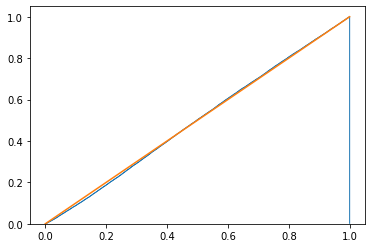

KstestResult(statistic=0.021584169453734647, pvalue=0.7438253974128554)

In [ ]:
import alphaquant.visualizations as aqviz
import scipy.stats as stats

plt.hist(pvals, cumulative=True, bins = 1000, histtype = "step", density = True)
x = np.linspace(0,1,100)
plt.plot(x, x)
plt.show()
unidist = np.random.uniform(size=1000)

res = stats.ks_2samp(pvals, unidist)
display(res)
#assert statement can be placed here!